# Visualization of CDER features  
Investigate CDER features and correlations with SME features via visualization
Author: Amish Mishra  
Date: April 5, 2022  
Use `cder1` kernel  

In [1]:
import pandas
import matplotlib.pyplot as plt
import numpy as np
import pickle
import seaborn as sns
import random
from IPython.display import display

In [2]:
def make_structured_corr_df(corr_df):
    '''
    Takes a correlation dataframe and returns a neatly made dataframe with informative columns
    :param corr_df: dataframe with correlations between cder coordinates and sme features
    :return: dataframe with information about sme, correlation, and cder coordinates
    '''
    structured_corr_df = pandas.DataFrame(columns=['corr', 'sme', 'cder_coord'])
    for col in corr_df:
        column = corr_df[col]
        for item in column.items():
            row = {'corr': item[1], 'sme': item[0], 'cder_coord': col}
            structured_corr_df.loc[len(structured_corr_df.index)] = row

    structured_corr_df = structured_corr_df.reset_index(drop=True)
    return structured_corr_df


def get_high_corr(corr_df, filter_type='thresh', filt=0.8):
    '''
    Takes a correlation dataframe and returns all high correlations according to specified filter_type
    :param corr_df: dataframe with correlations between cder coordinates and sme features
    :param filter_type: set to 'thresh' or 'top' for choosing correlations based on threshold or taking top correlations
    ;param filt: number specifying threshold to choose high correlations on or top number of correlations to choose
    :return: dataframe for scatterplot with correlations, cder coordinate names, and sme feature names
    '''
    scatterplt_df = pandas.DataFrame(columns=['corr', 'sme', 'cder_coord'])
    if filter_type == 'thresh':
        for col in corr_df:
            column = corr_df[col]
            high_corr = column[abs(column) > filt]
            if not high_corr.empty:
                for item in high_corr.items():
                    row = {'corr': item[1], 'sme': item[0], 'cder_coord': col}
                    scatterplt_df.loc[len(scatterplt_df.index)] = row
                    
    elif filter_type == 'top':
        max_indices = corr_df.abs().values.argsort(axis=0)[-filt:, :][::-1, :]
        for i, col in enumerate(max_indices.T):
            top_corr = pandas.DataFrame(corr_df.iloc[:, i].iloc[col])
            cder_coord_name = top_corr.columns[0]
            top_corr['sme'] = top_corr.index
            top_corr = top_corr.reset_index(drop=True)
            top_corr.columns = ['corr', 'sme']
            top_corr = top_corr.assign(cder_coord=cder_coord_name)
            scatterplt_df = pandas.concat([scatterplt_df, top_corr])
            
    scatterplt_df = scatterplt_df.reset_index(drop=True)
    return scatterplt_df


def label_highest(corr_df, filter_type='thresh', filt=0.8):
    '''
    Takes a correlation dataframe and deletes the sme label for all low correlations according to specified filter_type
    :param corr_df: dataframe with correlations between cder coordinates and sme features
    :param filter_type: set to 'thresh' or 'top' for choosing correlations based on threshold or taking top correlations
    ;param filt: number specifying threshold to choose high correlations on or top number of correlations to choose
    :return: dataframe for scatterplot with all correlations, cder coordinate names, and only highest correlated sme feature names
    '''
    modified_df = corr_df.copy()
    if filter_type == 'thresh':
        idxs = modified_df[abs(corr_df['corr']) < filt].index
        modified_df.loc[idxs, 'sme'] = 'other'
                      
    elif filter_type == 'top_imp':
        idxs = modified_df[modified_df['is_important'] == 0].index
        modified_df.loc[idxs, 'sme'] = 'other'
            
    return modified_df

def visual_scale_features(x):
    base_size = 30
    x *= 1000
    return base_size + x


def load_cder_model(file):
    """
    Loads data that was saved by gen_cder_model()
    :param file: path to cder model file
    :return:
    """
    with open(file, 'rb') as f:
        clouds, labels, ct_train, cder_model = pickle.load(f)

    return clouds, labels, ct_train, cder_model


def gaussian(x, mu, sig):
    '''Return gaussian for given parameters mu and sig'''
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))


def cder_gauss_plot(model_paths):
    h0_model_file = model_paths[0]
    h1_model_file = model_paths[1]
    h2_model_file = model_paths[2]
    cder_models = {}

    _, _, _, cder_models[0] = load_cder_model(h0_model_file)
    _, _, _, cder_models[1] = load_cder_model(h1_model_file)
    _, _, _, cder_models[2] = load_cder_model(h2_model_file)

    # create cder models into a dataframe
    cder_model_0_df = pandas.DataFrame(cder_models[0].gaussians)
    cder_model_1_df = pandas.DataFrame(cder_models[1].gaussians)
    cder_model_2_df = pandas.DataFrame(cder_models[2].gaussians)

    # weight each gaussian manually (by persistence or by 1)
    for gauss in cder_models[0].gaussians:
    #     gauss['weight'] = gauss['mean'][0]
        gauss['weight'] = 1

    for gauss in cder_models[1].gaussians:
    #     gauss['weight'] = gauss['mean'][1]
        gauss['weight'] = 1

    for gauss in cder_models[2].gaussians:
    #     gauss['weight'] = gauss['mean'][1]
        gauss['weight'] = 1


    # compute the plotting limits for x and y axes

    # H_0 plot limits
    h0_x_min = cder_model_0_df['mean'].min() - 2*cder_model_0_df['std'].max()
    h0_x_max = cder_model_0_df['mean'].max() + 2*cder_model_0_df['std'].max()

    # H_1 plot limits
    h1_x_min = 99
    h1_y_min = 99
    h1_x_max = 0
    h1_y_max = 0
    for means in cder_model_1_df['mean']:
        x_mean = means[0]
        y_mean = means[1]
        if x_mean < h1_x_min:
            h1_x_min = x_mean-3
        if x_mean > h1_x_max:
            h1_x_max = x_mean+3
        if y_mean < h1_y_min:
            h1_y_min = y_mean-3
        if y_mean > h1_y_max:
            h1_y_max = y_mean+3    

    # H_2 plot limits    
    h2_x_min = 99
    h2_y_min = 99
    h2_x_max = 0
    h2_y_max = 0
    for means in cder_model_2_df['mean']:
        x_mean = means[0]
        y_mean = means[1]
        if x_mean < h2_x_min:
            h2_x_min = x_mean-3
        if x_mean > h2_x_max:
            h2_x_max = x_mean+3
        if y_mean < h2_y_min:
            h2_y_min = y_mean-3
        if y_mean > h2_y_max:
            h2_y_max = y_mean+2 


    # Plot the CDER coordinates
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4), dpi=100)

    for j, style in enumerate(['gaussians']):
        # plot the H_0 Gaussians
        x_values = np.linspace(h0_x_min, h0_x_max, 1000)
        gauss_df = cder_model_0_df[['label', 'mean', 'std']]
        gauss_df
        for index, row in gauss_df.iterrows():
            mu = row['mean'][0]
            sig = row['std'][0]
            ax[0].plot(x_values, gaussian(x_values, mu, sig), color=row.label)

        # plot the H_1 Gaussians
        cder_models[1].plot(ax[1], style=style)

        # plot the H_2 Gaussians
        cder_models[2].plot(ax[2], style=style)


        ax[0].set_title(f'H_0 Distributional Coordinates \n ({len(cder_models[0].gaussians)} {style})')

        ax[1].set_xlim(h1_x_min, h1_x_max)
        ax[1].set_ylim(h1_y_min, h1_y_max)
        
        # Make the plot look square
        # calculate the ratio of the data range for the x and y axes
        x_range = h1_x_max - h1_x_min
        y_range = h1_y_max - h1_y_min
        ratio = y_range / x_range
        # set the aspect ratio to be the inverse of this ratio
        ax[1].set_aspect(1.0/ratio)
        ax[1].set_title(f'H_1 Distributional Coordinates \n ({len(cder_models[1].gaussians)} {style})')

        ax[2].set_xlim(h2_x_min, h2_x_max)
        ax[2].set_ylim(h2_y_min, h2_y_max)
        # Make the plot look square
        # calculate the ratio of the data range for the x and y axes
        x_range = h2_x_max - h2_x_min
        y_range = h2_y_max - h2_y_min
        ratio = y_range / x_range
        # set the aspect ratio to be the inverse of this ratio
        ax[2].set_aspect(1.0/ratio)
        ax[2].set_title(f'H_2 Distributional Coordinates \n ({len(cder_models[2].gaussians)} {style})')

#     fig.suptitle(str(topology) + " topology proteins")
    plt.tight_layout()
#     plt.savefig(f'figures/{topology}_cder_coords.svg', format='svg', bbox_inches='tight')
    plt.show()
    

def correlation_plot(scatterplt_df, cder_importance_order):
    sme_labels = scatterplt_df['sme'].unique().tolist()
    sme_labels.remove('other')
    sme_labels.append('other')
    
    # Get the "bright" color palette
    bright_palette = sns.color_palette("bright")

    # Define the starting color index
    start_color_index = 8  # Index of light blue in the "bright" palette

    # Generate a custom color palette starting from yellow
    color_palette = bright_palette[start_color_index:] + bright_palette[:start_color_index]

    # Create a dictionary mapping labels to colors
    label_color_map = dict(zip(sme_labels, color_palette))
    
    # Define CDER_coords as a categorical variable
    scatterplt_df['cder_coord'] = pandas.Categorical(scatterplt_df['cder_coord'], categories=cder_importance_order, ordered=True)
    
    fig, ax = plt.subplots(1,1, figsize=(16,9))
    scatter = sns.scatterplot(y = "cder_coord", x = "corr", hue = "sme", palette = label_color_map,# style="is_important", style_order=[1,0],
                            s=scatterplt_df["scaled_feature_imps"], alpha=0.7, hue_order=sme_labels,
                            data = scatterplt_df, ax=ax, legend='brief')

    # Jitter bubbles
    bubbles = ax.collections[0].get_offsets()
    for i, bubble in enumerate(bubbles):
        x = i%2
        sign = -2*x+1
        bubble[1] += sign*(np.random.rand()/3)


    # Format figure size, spines and grid
    # ax.figure.set_size_inches(12, 8)
    ax.margins(0, 0.1)
    ax.grid(axis='x', color='black', alpha=0.2)
    ax.grid(axis='y', which='minor', color='black')
    sns.despine(left=True)

    # Format ticks
    ax.tick_params(axis='both', length=0, pad=10, labelsize=12)
    # ax.tick_params(axis='y', which='minor', length=15, width=0.0 , color=[0, 0, 0, 0.2])
    minor_yticks = [tick+0.5 for tick in ax.get_yticks() if tick != ax.get_yticks()[-1]]
    ax.set_yticks(minor_yticks, minor=True)
    ax.set_xticks(np.linspace(-1,1,9))
    
    # Color and bolden ytick labels based on their names and max absolute correlation number
    for label in ax.get_yticklabels():
        label.set_weight('bold')
        label_name = label.get_text()
        label_abs_max_corr = scatterplt_df.loc[scatterplt_df['cder_coord']== label_name, 'corr'].abs().max()
        if 'red' in label_name:
            label.set_color('red')
        elif 'green' in label_name:
            label.set_color('green')

    # Edit labels and legend
    ax.set_xlabel('Correlation', labelpad=15, size=16)
    ax.set_ylabel('CDER Features', labelpad=15, size=16)
    lgnd = ax.legend(title='SME Features', loc='upper center', frameon=True, bbox_to_anchor=(0.5, 1.12), ncol=5)
    # Make the legend title bold
    lgnd.get_title().set_fontweight('bold')
    
#     ax.set_title('scatterplot of CDER coordinates correlations with SME features'+
#               '\n Showing '+str(len(scatterplt_df))+' correlations')
#     plt.savefig(f'figures/{topology}_corr.svg', format='svg', bbox_inches='tight')
    plt.show()

## Plot highest correlations by CDER coordinates

### Find correlations between CDER coordinates and SME features

In [3]:
# Load in the performance dataframe
topology = 'HHH'
perf_df = pandas.read_csv('perf_dataframes/sme_cder_perf_df_downsample_no_train_test_split.csv')
row = perf_df.loc[(perf_df['topology'] == topology)]
raw_feature_df_paths = row['features_df_path'].iloc[0]

# Extract the feature dataframe path of interest
data_type = 'train_X'
feature_df_paths = raw_feature_df_paths[1:-1].split(', ')
for i, path in enumerate(feature_df_paths):
    feature_df_paths[i] = path[1:-1] # remove apostrophes

for path in feature_df_paths:
    if data_type in path:
        feature_path  = path
        
# Extract the CDER models path
cder_models_paths = row['cder_models_path'].iloc[0][1:-1].split(', ')
for i, path in enumerate(cder_models_paths):
    cder_models_paths[i] = path[1:-1] # remove apostrophes
    
# Load in the features dataframe and find correlation
features_df = pandas.read_csv(feature_path)
corr_df = features_df.corr().dropna(how='all', axis=0).dropna(how='all', axis=1)

print(corr_df.shape)
## Display correlations
# corr_df.style.background_gradient(cmap='RdBu_r')

(112, 112)


### Process and prepare dataframe for plotting

In [4]:
# filter to only get the cder coordinate correlations with only the SME features
filtered_corr = corr_df.filter(regex='^H_', axis=1).filter(regex='^[^H_]', axis=0)
structured_df = make_structured_corr_df(filtered_corr)

# Append the mean feature importances for each sme feature
save_path = './sme_feature_importances_dataframes'
top = topology

# Find the feature importances for this iteration
features_df = pandas.read_csv(f'{save_path}/{top}_sme_feature_importances_no_train_test_split_df.csv', index_col=0)
feature_imp = features_df['feature_imp']
structured_df['feature_imps'] = structured_df['sme'].map(feature_imp)
structured_df['scaled_feature_imps'] = structured_df['feature_imps'].map(visual_scale_features)

# Mark the top most important features
structured_df['is_important'] =  structured_df['sme'].map(lambda x: 1 if x in feature_imp.nlargest(9).index else 0)

# Only label the SME features with high importance for the plot
filter_type = 'top_imp'
filt = None
scatterplt_df = label_highest(structured_df, filter_type=filter_type, filt=filt)

display(scatterplt_df.head())
print(scatterplt_df.shape)

,corr,sme,cder_coord,feature_imps,scaled_feature_imps,is_important
0,-0.725302,other,H_0_green[-1.1],0.014935,44.935484,0
1,-0.027728,other,H_0_green[-1.1],0.000000,30.000000,0
2,0.236719,other,H_0_green[-1.1],0.000000,30.000000,0
3,-0.011327,other,H_0_green[-1.1],0.000000,30.000000,0
4,0.066949,other,H_0_green[-1.1],0.000000,30.000000,0


(832, 6)


### Plot

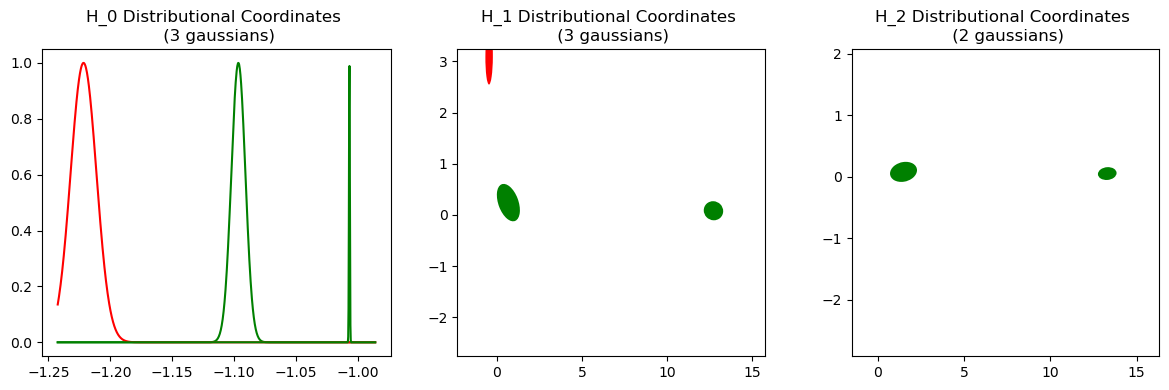

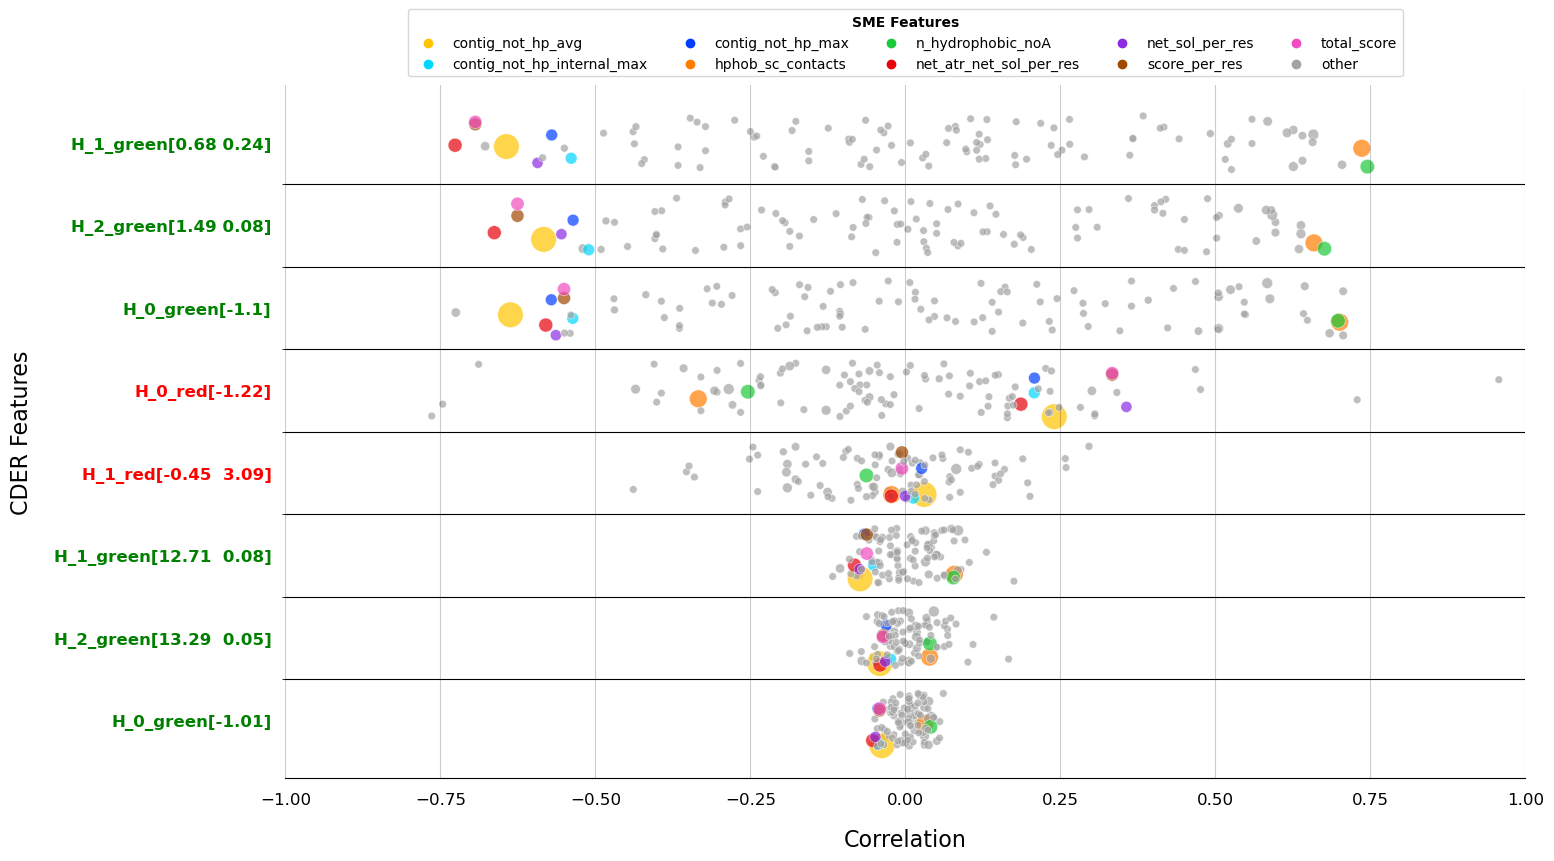

In [5]:
# Create CDER plot
cder_gauss_plot(cder_models_paths)

# Find the order the CDER features have in importance
save_path = './cder_feature_importances_dataframes'
cder_features_df = pandas.read_csv(f'{save_path}/{topology}_cder_feature_importances_no_train_test_split_df.csv', index_col=0)
largest_importances = cder_features_df.nlargest(n=len(cder_features_df), columns=['feature_imp'])

# Create correlations plot
correlation_plot(scatterplt_df, largest_importances.index.to_numpy())

## Plot CDER features vs stability scores

,H_0_green[-1.1],H_0_red[-1.22],H_0_green[-1.01],H_1_green[0.68 0.24],H_1_red[-0.45 3.09],H_1_green[12.71 0.08],H_2_green[1.49 0.08],H_2_green[13.29 0.05],Stability score
0,1.671966,0.289106,-0.0416,1.527126,0.026536,0.395279,0.987746,-0.339934,2.675084
1,1.344920,-0.500393,-0.0416,0.965651,-0.051902,-0.399008,0.701553,-0.347603,2.663947
2,1.059022,-1.062204,-0.0416,0.492777,-0.568964,-0.399008,0.893322,-0.347603,2.614201
3,1.067622,0.558738,-0.0416,1.599651,-0.553444,-0.399008,0.885366,2.284732,2.613560
4,0.078182,0.924728,-0.0416,0.732101,0.315884,2.114934,0.609047,0.889409,2.610852


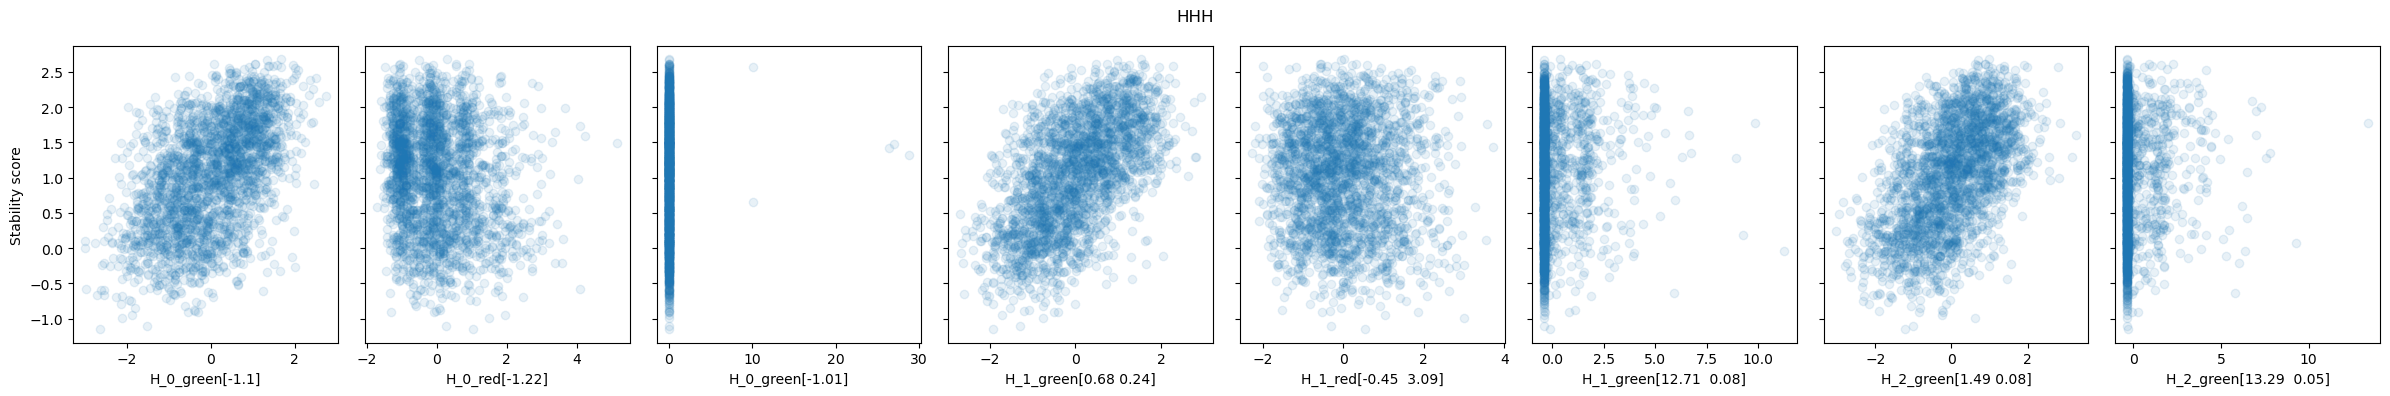

,H_0_green[-1.22],H_0_green[-0.94],H_0_green[-1.07],H_1_green[0.73 0.24],H_1_red[-0.44 2.84],H_1_green[2.537e+01 2.000e-02],H_2_green[1.68 0.08],H_2_red[11.69 0.08],H_2_green[25.54 0.06],Stability score
0,0.994737,-0.526432,0.041410,1.132969,-1.268669,-0.050998,1.018505,-0.578888,-0.043869,2.258980
1,1.636937,1.024796,0.950580,1.281241,-1.240985,-0.050998,1.212267,0.177083,-0.043869,2.211290
2,0.508795,0.979143,-1.617476,1.125727,0.121073,-0.050998,1.181823,0.019809,-0.043869,2.188392
3,0.476725,0.978344,-0.461101,0.653172,-0.149090,-0.050998,0.723563,-0.576167,-0.043869,2.118166
4,0.089888,1.143112,-0.226048,0.586521,-0.339349,-0.050998,-0.018092,0.275291,-0.043869,2.085016


<Figure size 640x480 with 0 Axes>

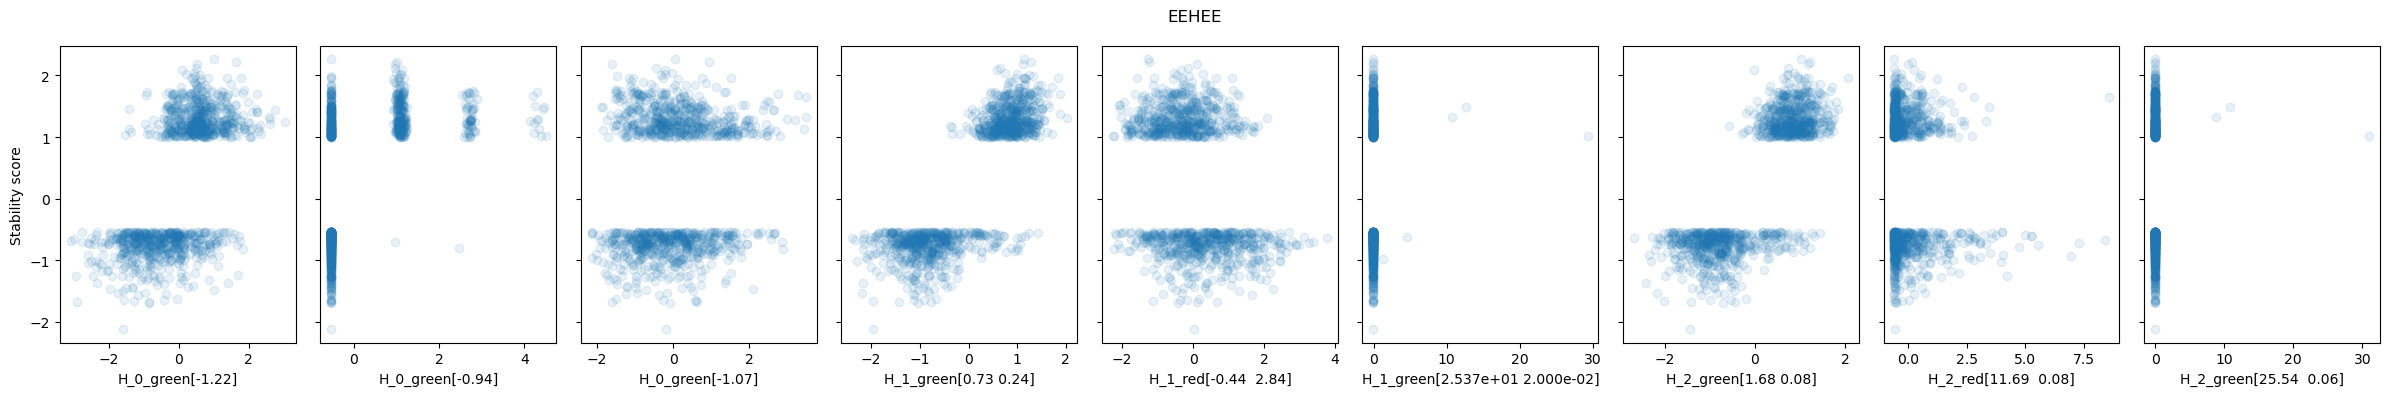

,H_0_green[-1.1],H_0_red[-1.24],H_0_green[-0.94],H_0_green[-1.21],H_1_green[0.69 0.24],H_1_red[-0.41 2.95],H_1_red[27.75 0.04],H_1_green[11.89 0.13],H_2_green[1.53 0.08],H_2_red[11.09 0.11],Stability score
0,0.227395,-1.981036,-0.146978,3.584468,1.493374,-0.354593,-0.065233,0.879726,0.645413,-0.243679,2.104380
1,0.820840,-0.768033,-0.146978,3.306975,-0.629564,0.501056,-0.065233,-0.403291,-0.189469,-0.470106,1.923464
2,0.333391,-1.237503,-0.146978,0.831047,1.829163,-2.093361,-0.065233,1.367678,2.249126,0.384569,1.861685
3,1.899058,0.069792,-0.146978,-0.664006,1.033773,-0.252720,-0.065233,-0.402923,0.304388,-0.462833,1.837557
4,2.041761,-0.773665,-0.146978,2.050703,0.785791,-0.915777,-0.065233,2.782184,1.108638,1.090914,1.814677


<Figure size 640x480 with 0 Axes>

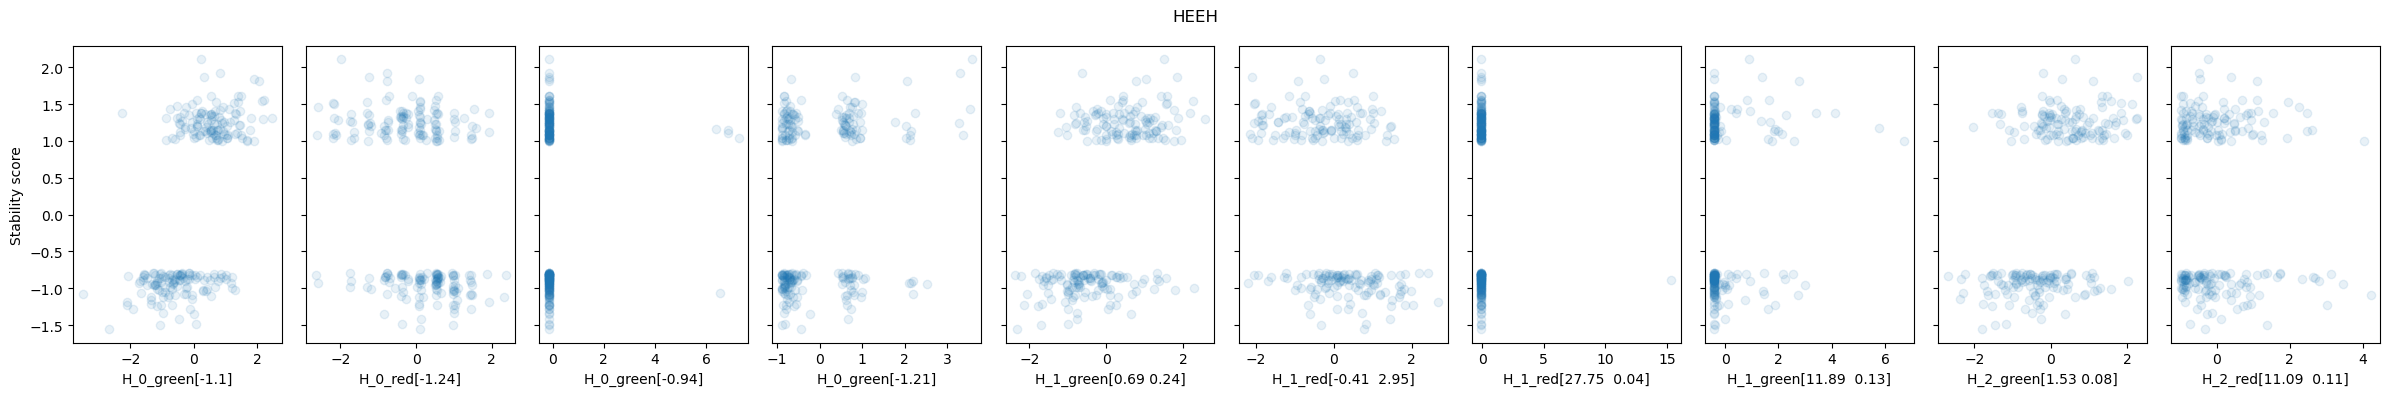

,H_0_red[-1.1],H_0_green[-1.22],H_0_red[-1.24],H_0_green[-0.94],H_1_green[0.71 0.23],H_1_green[19.47 0.14],H_2_green[1.61 0.08],H_2_green[19.25 0.04],Stability score
0,0.688921,2.025754,-1.676620,0.870886,0.014107,0.033413,0.258377,-0.092887,2.472887
1,2.369078,-1.248823,-2.572457,2.212043,1.343041,-0.131653,2.143946,-0.092887,2.445394
2,0.936138,-0.033439,0.059660,-0.537257,0.066063,-0.131653,-0.620175,-0.092887,2.440287
3,0.666821,0.108782,-1.223078,0.790818,0.003701,-0.131653,1.230008,-0.092887,2.417450
4,1.472587,-0.293028,-1.014676,2.252108,1.213014,-0.130057,0.215066,-0.092887,2.405921


<Figure size 640x480 with 0 Axes>

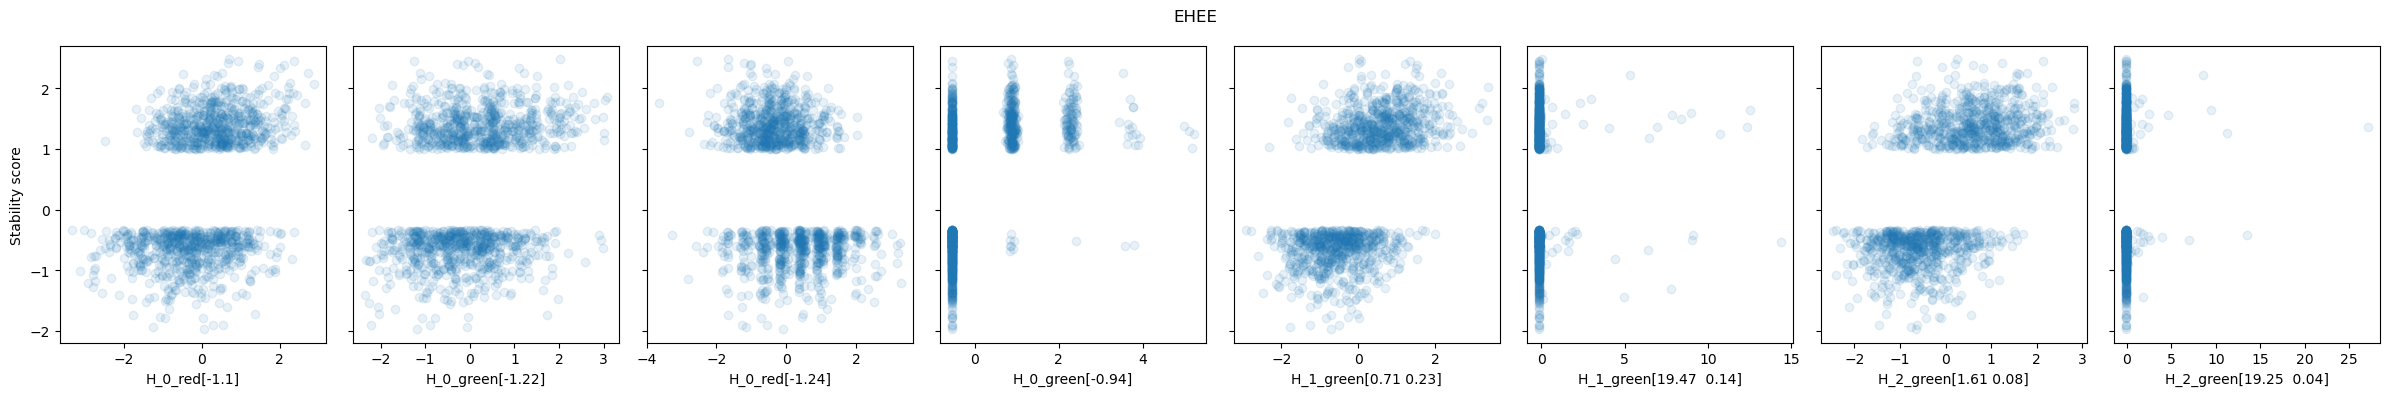

<Figure size 640x480 with 0 Axes>

In [17]:
from matplotlib.backends.backend_pdf import PdfPages

pdf = PdfPages('figures/output.pdf')

# Load in stability scores dataframe the way it was done in the sme-cder-ml file
raw_df = pandas.read_csv('main_df.csv')
topologies_arr = raw_df['topology'].unique()  # store the different topology types

for topology in topologies_arr:    
    # Load in the features dataframe
    perf_df = pandas.read_csv('perf_dataframes/sme_cder_perf_df_downsample_no_train_test_split.csv')
    row = perf_df.loc[(perf_df['topology'] == topology)]
    raw_feature_df_paths = row['features_df_path'].iloc[0]

    # Extract the feature dataframe path of interest
    data_type = 'train_X'
    feature_df_paths = raw_feature_df_paths[1:-1].split(', ')
    for i, path in enumerate(feature_df_paths):
        feature_df_paths[i] = path[1:-1] # remove apostrophes

    for path in feature_df_paths:
        if data_type in path:
            feature_path  = path
    features_df = pandas.read_csv(feature_path).filter(regex='^H_', axis=1)
    
    stability_threshold = 1.0  # set the stability score at which to separate the stable label from the unstable label
    stable_proportion = 1  # determines what portion of the stable proteins to use
    max_num = 10000  # max number of proteins to pick for each topology

    main_df = pandas.DataFrame(columns = raw_df.columns)
    for top in topologies_arr:
        temp_df = raw_df.groupby('topology').get_group(top)
        num_stable = sum(temp_df['stabilityscore_cnn_calibrated'] > stability_threshold)
        num_unstable = sum(temp_df['stabilityscore_cnn_calibrated'] <= stability_threshold)
        stable_num_to_choose = int(stable_proportion*(num_stable))
        if (stable_num_to_choose > max_num):
            stable_num_to_choose = max_num  # choose no more than the allowed max
        if (num_unstable < stable_num_to_choose):
            unstable_num_to_choose = num_unstable  # set max on unstable proteins
        else:
            unstable_num_to_choose = stable_num_to_choose  
#         print('Choosing', stable_num_to_choose, 'stable designs out of', num_stable,'for', top)
#         print('Choosing', unstable_num_to_choose, 'unstable designs out of', num_unstable, 'for', top)

        most_stable = temp_df.nlargest(n=stable_num_to_choose, columns='stabilityscore_cnn_calibrated')
        least_stable = temp_df.nsmallest(n=unstable_num_to_choose, columns='stabilityscore_cnn_calibrated')
        most_stable = most_stable.reset_index(drop=True)
        least_stable = least_stable.reset_index(drop=True)
        main_df = pandas.concat([main_df, most_stable, least_stable])
    
    main_df = main_df.loc[(main_df['topology'] == topology)]
    main_df = main_df.reset_index(drop=True)

    # Create new dataframe for plotting cder coords vs stability scores
    cder_stab_df = pandas.concat([features_df, main_df['stabilityscore_cnn_calibrated']], axis=1)
    cder_stab_df = cder_stab_df.rename(columns={'stabilityscore_cnn_calibrated': 'Stability score'})
    display(cder_stab_df.head())

    # Create subplots for scatterplots and histograms
    fig, axs = plt.subplots(nrows=1, ncols=len(cder_stab_df.columns) - 1, sharey=True, figsize=(24, 4))

    fig.suptitle(topology)

    # Draw the scatter plot and marginals.
    for i, col in enumerate(cder_stab_df.columns[:-1]):
        axs[i].scatter(cder_stab_df[col], cder_stab_df['Stability score'], alpha=0.1)
        axs[i].set_xlabel(col)
    axs[0].set_ylabel('Stability score')

    plt.tight_layout()
    
    pdf.savefig(fig)

    # Display the plot
    plt.show()
    plt.clf()
    
pdf.close()